# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.255409,False,0.004099
1,0.840175,True,4.288417
2,0.181350,True,5.904492
3,2.862424,True,5.031135
4,0.729631,False,1.807294
...,...,...,...
995,0.824080,True,3.327751
996,2.117673,True,5.631327
997,-0.053550,False,-0.192348
998,1.222240,True,8.158245


<AxesSubplot: xlabel='v0'>

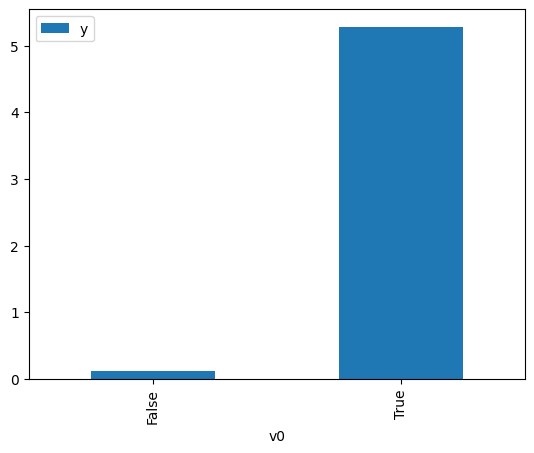

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

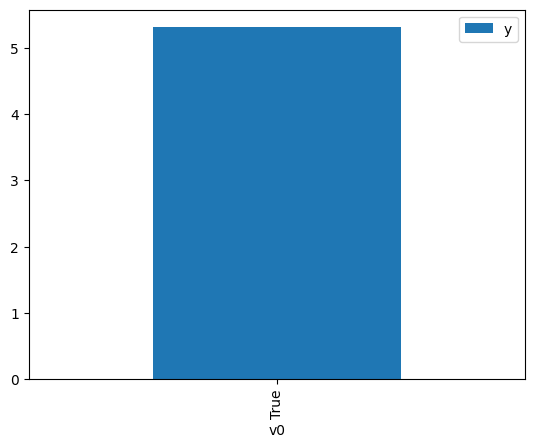

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.961316,False,2.283123,0.155246,6.441372
1,2.358405,False,0.979806,0.014005,71.401378
2,-0.546683,False,0.666149,0.744482,1.343217
3,0.621487,False,2.136768,0.255158,3.919144
4,-0.934239,False,0.247119,0.855647,1.168707
...,...,...,...,...,...
995,-0.035449,False,0.415312,0.533089,1.875858
996,0.745569,False,-0.335327,0.214389,4.664428
997,0.897021,False,0.721672,0.171333,5.836590
998,0.635104,False,-0.346212,0.250444,3.992906


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.050595,True,4.690912,0.865021,1.156041
1,0.811144,True,4.217163,0.805156,1.241995
2,0.227378,True,3.985521,0.586395,1.705335
3,1.889638,True,5.455703,0.967554,1.033534
4,0.227427,True,4.787850,0.586417,1.705273
...,...,...,...,...,...
995,1.250640,True,6.709029,0.902404,1.108152
996,1.628029,True,5.740778,0.948622,1.054161
997,2.551384,True,4.509149,0.990125,1.009973
998,1.160265,True,5.243985,0.886815,1.127631


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.063e+04
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:13:36   Log-Likelihood:                         -1397.9
No. Observations:                1000   AIC:                                      2800.
Df Residuals:                     998   BIC:                                      2810.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2970      0.035      8.474      0.000       0.228       0.366
x2             5.0729      0.055     92.112      0.000       4.965       5.181
==============================================================================
Omnibus:                        4.484   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.466
Skew:                           0.140   Prob(JB):                        0.107
Kurtosis:                       2.829   Cond. No.                         2.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""